In [1]:
%matplotlib inline
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from collections import OrderedDict, Counter
plt.style.use('ggplot')

utils = reload('utils.utils')
np.set_printoptions(precision=4, suppress=True, linewidth=100)
randomSeed = 88
np.random.seed(randomSeed)

<br/>
<br/>
<br/>
## Data Prepare
```
mapping user id, movie id to zero start indices
```

In [2]:
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
movies = pd.read_csv("./data/ml-latest-small/movies.csv")
tags = pd.read_csv("./data/ml-latest-small/tags.csv")

uidEnc, midEnc = LabelEncoder(), LabelEncoder()
# encode user id and movie id to real value
midEnc.fit(movies.movieId)
uidEnc.fit(ratings.userId)

ratings["userId"] = uidEnc.transform(ratings.userId)
ratings["movieId"] = midEnc.transform(ratings.movieId)

movies["movieId"] = midEnc.transform(movies.movieId)

tags["userId"] = uidEnc.transform(tags.userId)
tags["movieId"] = midEnc.transform(tags.movieId)

midMap = pd.Series(dict(zip(movies.movieId, movies.title)))

nUsers, nMovies = len(uidEnc.classes_), len(midEnc.classes_)

print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [3]:
# movies profile
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


In [4]:
# tags profile
tags.head()

,userId,movieId,tag,timestamp
0,14,304,sandra 'boring' bullock,1138537770
1,14,1517,dentist,1193435061
2,14,5166,Cambodia,1170560997
3,14,6118,Russian,1170626366
4,14,6178,forgettable,1141391765


<br/>
<br/>
<br/>
### Split Train and Test Data
```
1. 拆分train test data
2. number of user = 671, number of movies = 9125 => movie數量越大於user數量則越貼近現實
3. 組合interaction matrix of train and test data
```

In [5]:
# # 已經產生出檔案的不用跑這一段
# tr, te = utils.split_ratings(ratings, testRatio=0.3)
# tr.to_csv("./data/ml-latest-small/movielens.tr.csv", index=False)
# te.to_csv("./data/ml-latest-small/movielens.te.csv", index=False)
# utils.dumpPickle("./data/ml-latest-small/state.h", 
#         {"uidEnc": uidEnc, "midEnc": midEnc, "midMap": midMap, "nUsers": nUsers, "nMovies":nMovies})

In [3]:
tr = pd.read_csv("./data/ml-latest-small/movielens.tr.csv")
te = pd.read_csv("./data/ml-latest-small/movielens.te.csv")

state = utils.loadPickle("./data/ml-latest-small/state.h")
uidEnc, midEnc, midMap, nUsers, nMovies = \
    (state["uidEnc"], state["midEnc"], state["midMap"], state["nUsers"], state["nMovies"])

# train data rating matrix
trRatingMat = np.zeros((nUsers, nMovies))
# test data rating matrix
teRatingMat = np.zeros((nUsers, nMovies))
for idx, r in tr.iterrows():
    trRatingMat[int(r.userId), int(r.movieId)] = r.rating
for idx, r in te.iterrows():
    teRatingMat[int(r.userId), int(r.movieId)] = r.rating

print("train interaction matrix shape: ", trRatingMat.shape, "test interaction matrix shape: ", teRatingMat.shape)
print("train.shape: ", tr.shape, "test.shape: ", te.shape)
print()
print(tr.head())
print()
print(te.head())

train interaction matrix shape:  (671, 9125) test interaction matrix shape:  (671, 9125)
train.shape:  (69399, 4) test.shape:  (30605, 4)

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


### 以leave one out方式產生 train data, test data
```python
1. 每一筆資料有兩部分: [user query] + [item meta]
2. movie多加了兩個欄位: avg_rating, year
    - avg_rating是所有user對於同一部電影的平均評分
    - year則是從title extract出來的資訊
3. 每一筆user query 包含所有user movie history, 除了當前的rating movie (candidate movie)
4. test data的user query來自於train data
```

In [4]:
def preprocess(data, movie_trans, train_hist=None, is_train=True):
    queue = []
    data = data.merge(movie_trans, how="left", on="movieId")
    columns=["user_id", "query_movie_ids", 
             "genres", "avg_rating", "year", "candidate_movie_id",
             "rating"]
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        if not is_train:
            user_movies_hist = train_hist.query("userId == {}".format(u)).movieId
        for i, (_, r) in enumerate(df.iterrows()):
            if is_train:
                queue.append([int(r.userId), df.movieId[:i].tolist() + df.movieId[i + 1:].tolist(), r.genres, r.avg_rating, r.year, int(r.movieId), r.rating])
            else:
                # queue.append([int(r.userId), df.movieId[:i].tolist() + df.movieId[i + 1:].tolist(), r.genres, r.avg_rating, r.year, int(r.movieId), r.rating])
                all_hist = set(user_movies_hist.tolist() + df.movieId[:i].tolist())
                queue.append([int(r.userId), list(all_hist - set([int(r.movieId)])), r.genres, r.avg_rating, r.year, int(r.movieId), r.rating])
    return pd.DataFrame(queue, columns=columns)

movie_trans, genres_enc = utils.doMovies(movies)
movie_trans["avg_rating"] = ratings.groupby("movieId").rating.mean()
movie_trans["avg_rating"] = minmax_scale(movie_trans.avg_rating.fillna(ratings.rating.mean()))
movie_trans["year"] = movie_trans.title.str.findall("\(\s*(\d+)\s*\)").map(lambda lst: int(lst[-1]) if len(lst) else None)
movie_trans["year"] = minmax_scale(movie_trans.year.fillna(movie_trans.year.median()))
n_genres = len(genres_enc.enc)

trProcessed = preprocess(tr, movie_trans)
teProcessed = preprocess(te, movie_trans, tr, is_train=False)
trProcessed.head()

,user_id,query_movie_ids,genres,avg_rating,year,candidate_movie_id,rating
0,0,"[1515, 1083, 833, 859, 30, 1111, 906, 1017, 10...",[0],0.835749,0.763158,931,4.0
1,0,"[931, 1083, 833, 859, 30, 1111, 906, 1017, 104...","[3, 6, 2]",0.782609,0.605263,1515,4.0
2,0,"[931, 1515, 833, 859, 30, 1111, 906, 1017, 104...","[9, 7, 4, 2]",0.621795,0.789474,1083,3.5
3,0,"[931, 1515, 1083, 859, 30, 1111, 906, 1017, 10...","[13, 10, 0, 14]",0.711640,0.342105,833,3.0
4,0,"[931, 1515, 1083, 833, 30, 1111, 906, 1017, 10...",[2],0.676768,0.824561,859,3.0


In [5]:
teProcessed.head()

,user_id,query_movie_ids,genres,avg_rating,year,candidate_movie_id,rating
0,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...","[3, 5, 8]",0.661939,0.701754,1665,4.0
1,0,"[833, 1665, 931, 1083, 906, 1515, 1041, 1140, ...","[5, 1]",0.669753,0.684211,1708,3.0
2,0,"[833, 1665, 931, 1083, 906, 1515, 1708, 1041, ...","[1, 16]",0.763441,0.631579,2925,3.0
3,0,"[833, 1665, 906, 1041, 1111, 1047, 859, 30, 93...","[0, 7, 8, 2]",0.643026,0.736842,1962,2.5
4,0,"[833, 1665, 906, 1041, 1111, 1047, 859, 30, 93...","[3, 5, 9]",0.600529,0.754386,1743,2.0


### Data Function
```python
1. 由於tensorflow placeholder不支援變動長度的columns, 需透過padding zero(補零)帶入
2. 每個變動長度的column, 需要再給lens描述每一筆資料的長度, ex: genres, genres_len
```

In [6]:
def do_multi(df, multi_cols):
    """對於multivalent的欄位, 需要增加一個column去描述該欄位的長度"""
    pad = tf.keras.preprocessing.sequence.pad_sequences
    ret = OrderedDict()
    for colname, col in df.iteritems():
        if colname in multi_cols:
            lens = col.map(len)
            ret[colname] = list(pad(col, padding="post", maxlen=lens.max()))
            ret[colname + "_len"] = lens.values
        else:
            ret[colname] = col.values
    return ret

def dataFn(data, n_batch=128, shuffle=False):
    pad = tf.keras.preprocessing.sequence.pad_sequences
    def fn():
        dataInner = data.copy()
        indices = utils.get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
        for ind in indices:
            yield do_multi(dataInner.iloc[ind], ["query_movie_ids", "genres"])
    return fn

for i, e in enumerate(dataFn(trProcessed, n_batch=5, shuffle=True)(), 1):
    # print(e)
    break
pd.DataFrame(e)

,user_id,query_movie_ids,query_movie_ids_len,genres,genres_len,avg_rating,year,candidate_movie_id,rating
0,47,"[263, 2860, 3856, 6034, 2409, 2374, 7128, 5339...",357,"[1, 0, 4, 0]",3,0.716049,0.833333,1393,4.5
1,175,"[966, 5026, 4395, 6042, 3871, 6521, 5020, 953,...",177,"[5, 13, 10, 1]",4,0.643739,0.877193,4002,3.0
2,261,"[45, 1104, 154, 4514, 4171, 3801, 3727, 3644, ...",471,"[0, 7, 2, 0]",3,0.545752,0.859649,3089,2.0
3,479,"[0, 4815, 1, 4557, 4398, 4395, 969, 4325, 1019...",263,"[7, 11, 2, 0]",3,0.448148,0.833333,1308,3.0
4,345,"[3595, 3506, 2308, 3319, 3299, 1379, 3290, 275...",229,"[1, 0, 0, 0]",1,0.779449,0.736842,2340,1.5


## MF + DNN with Pointwise Loss Function (RMSE or L2 loss)

In [10]:
class ModelMfDNN(object):
    def __init__(self,
                 n_items,
                 n_genres,
                 dim=32,
                 learning_rate=0.01,
                 modelDir="./model/model_mf_with_dnn"):
        """初始化 Tensorflow Graph"""
        self.n_items = n_items
        self.n_genres = n_genres
        self.ftr_cols = OrderedDict()

        graph = tf.Graph()
        with graph.as_default():
            # inputs/id_user:0
            with tf.variable_scope("inputs"):
                self.isTrain = tf.placeholder(tf.bool, None)
                # user data
                self.user_id = tf.placeholder(tf.int32, [None])
                self.query_movie_ids = tf.placeholder(tf.int32, [None, None])
                self.query_movie_ids_len = tf.placeholder(tf.int32, [None])
                # item data
                self.genres = tf.placeholder(tf.int32, [None, None])
                self.genres_len = tf.placeholder(tf.int32, [None])
                self.avg_rating = tf.placeholder(tf.float32, [None])
                self.year = tf.placeholder(tf.float32, [None])
                self.candidate_movie_id = tf.placeholder(tf.int32, [None])
                self.rating = tf.placeholder(tf.float32, [None])

            init_fn = tf.glorot_normal_initializer()
            emb_init_fn = tf.glorot_uniform_initializer()
            self.b_global = tf.Variable(emb_init_fn(shape=[]), name="b_global")
            with tf.variable_scope("embedding"):
                self.w_query_movie_ids = tf.Variable(emb_init_fn(shape=[self.n_items, dim]), name="w_query_movie_ids")
                self.b_query_movie_ids = tf.Variable(emb_init_fn(shape=[dim]), name="b_query_movie_ids")
                self.w_candidate_movie_id = tf.Variable(init_fn(shape=[self.n_items, dim]), name="w_candidate_movie_id")
                self.b_candidate_movie_id = tf.Variable(init_fn(shape=[dim + 8 + 2]), name="b_candidate_movie_id")
                self.w_genres = tf.Variable(emb_init_fn(shape=[self.n_genres, 8]), name="w_genres")

                self.query_emb = tf.nn.embedding_lookup(self.w_query_movie_ids, self.query_movie_ids)
                query_movie_mask = tf.expand_dims(tf.nn.l2_normalize(tf.to_float(tf.sequence_mask(self.query_movie_ids_len)), 1), -1)
                self.query_emb = tf.reduce_sum(self.query_emb * query_movie_mask, 1)
                # Do: 若發生overfitting, 則對query_emb, candidate_emb dropout, 調整drop rate [0.3 ~ 0.7]
                # self.query_emb = tf.layers.dropout(self.query_emb, 0.5, training=self.isTrain)
                self.query_bias = tf.matmul(self.query_emb, self.b_query_movie_ids[:, tf.newaxis])

                # candidate_movie embedding
                self.candidate_emb = tf.nn.embedding_lookup(self.w_candidate_movie_id, self.candidate_movie_id)

                # genres embedding
                self.genres_emb = tf.nn.embedding_lookup(self.w_genres, tf.to_int32(self.genres))
                genres_mask = tf.expand_dims( tf.nn.l2_normalize(tf.to_float(tf.sequence_mask( tf.reshape(self.genres_len, [-1])) ), 1), -1)
                self.genres_emb = tf.reduce_sum(self.genres_emb * genres_mask, 1)

            # encode [item embedding + item metadata]
            with tf.variable_scope("dnn"):
                self.item_repr = tf.concat([self.candidate_emb, self.genres_emb, self.avg_rating[:, tf.newaxis], self.year[:, tf.newaxis]], 1)
                self.candidate_bias = tf.matmul(self.item_repr, self.b_candidate_movie_id[:, tf.newaxis])
                
                # Do: 若發生overfitting, 則對每一層item_repr hidden layer dropout, 調整drop rate [0.3 ~ 0.7]
                dp_scale = 0.5
                # self.item_repr = tf.layers.dropout(self.item_repr, dp_scale, training=self.isTrain)
                self.item_repr = tf.layers.dense(self.item_repr, dim, kernel_initializer=init_fn, activation=tf.nn.relu)
                # self.item_repr = tf.layers.dropout(self.item_repr, dp_scale, training=self.isTrain)
                self.item_repr = tf.layers.dense(self.item_repr, dim, kernel_initializer=init_fn, activation=tf.nn.relu)
                # self.item_repr = tf.layers.dropout(self.item_repr, dp_scale, training=self.isTrain)

            with tf.variable_scope("computation"):
                infer = tf.reduce_sum(self.query_emb * self.item_repr, 1, keep_dims=True)
                infer = tf.add(infer, self.b_global)
                infer = tf.add(infer, self.query_bias)
                self.infer = tf.add(infer, self.candidate_bias, name="infer")

                # one query for all items
                self.pred = tf.matmul(self.query_emb, tf.transpose(self.item_repr)) + \
                            tf.reshape(self.candidate_bias, (1, -1)) + self.query_bias + self.b_global

            with tf.variable_scope("loss"):
                # Do: 使用l2_loss or mean square error
                self.loss = tf.nn.l2_loss(self.infer - self.rating[:, tf.newaxis])
                # self.loss = tf.losses.mean_squared_error(labels=self.rating[:, tf.newaxis], predictions=self.infer)

                # for eval
                self.rmse_loss = tf.sqrt(self.loss)
                self.mae_loss = tf.reduce_mean(tf.abs(self.infer - self.rating[:, tf.newaxis]))
                pass

            with tf.variable_scope("train"):
                # Do: 使用不同的optimizer
                self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
                # self.train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)
                # self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
                pass

            self.saver = tf.train.Saver(tf.global_variables())
            self.graph = graph
            self.modelDir = modelDir

    def resetModel(self, modelDir):
        shutil.rmtree(path=modelDir, ignore_errors=True)
        os.makedirs(modelDir)

    def feed_dict(self, data, mode="train"):
        ret = {
            self.user_id: data["user_id"],
            self.query_movie_ids: data["query_movie_ids"],
            self.query_movie_ids_len: data["query_movie_ids_len"],
            self.genres: data["genres"],
            self.genres_len: data["genres_len"],
            self.avg_rating: data["avg_rating"],
            self.year: data["year"],
            self.candidate_movie_id: data["candidate_movie_id"]
        }
        ret[self.isTrain] = False
        if mode != "infer":
            ret[self.rating] = data["rating"]
            if mode == "train":
                ret[self.isTrain] = True
            elif mode == "eval":
                pass
        return ret

    def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
        sess.run(tf.global_variables_initializer())
        if reset:
            print("reset model: clean model dir: {} ...".format(self.modelDir))
            self.resetModel(self.modelDir)
        self.ckpt(sess, self.modelDir)

        start = time.time()
        print("%s\t%s\t%s\t%s" % ("Epoch", "Train Error", "Val Error", "Elapsed Time"))
        minLoss = 1e7
        for ep in range(1, nEpoch + 1):
            tr_loss, tr_total = 0, 0
            for i, data in enumerate(trainGen(), 1):
                loss, _ = sess.run([self.rmse_loss, self.train_op], feed_dict=self.feed_dict(data, mode="train"))
                tr_loss += loss ** 2 * len(data["query_movie_ids"])
                tr_total += len(data["query_movie_ids"])
                print("\rtrain loss: {:.3f}".format(loss), end="")
            if testGen is not None:
                epochLoss = self.epochLoss(sess, testGen)

            tpl = "\r%02d\t%.3f\t\t%.3f\t\t%.3f secs"
            if minLoss > epochLoss:
                tpl += ", saving ..."
                self.saver.save(sess, os.path.join(self.modelDir, 'model'), global_step=ep)
                minLoss = epochLoss

            end = time.time()
            print(tpl % (ep, np.sqrt(tr_loss / tr_total), epochLoss, end - start))
            start = end
        return self

    def ckpt(self, sess, modelDir):
        """load latest saved model"""
        latestCkpt = tf.train.latest_checkpoint(modelDir)
        if latestCkpt:
            self.saver.restore(sess, latestCkpt)
        return latestCkpt

    def epochLoss(self, sess, dataGen, tpe="rmse"):
        totLoss, totCnt = 0, 0
        for data in dataGen():
            lossTensor = self.rmse_loss if tpe == "rmse" else self.mae_loss
            loss = sess.run(lossTensor, feed_dict=self.feed_dict(data, mode="eval"))
            totLoss += (loss ** 2 if tpe == "rmse" else loss) * len(data["query_movie_ids"])
            totCnt += len(data["query_movie_ids"])
        return np.sqrt(totLoss / totCnt) if tpe == "rmse" else totLoss / totCnt

    def predict(self, sess, user_queries, items):
        self.ckpt(sess, self.modelDir)
        return sess.run(self.pred, feed_dict={
            self.isTrain: False,
            self.user_id: user_queries["user_id"],
            self.query_movie_ids: user_queries["query_movie_ids"],
            self.query_movie_ids_len: user_queries["query_movie_ids_len"],

            self.genres: items["genres"],
            self.genres_len: items["genres_len"],
            self.avg_rating: items["avg_rating"],
            self.year: items["year"],
            self.candidate_movie_id: items["candidate_movie_id"]
        })

    def evaluateRMSE(self, sess, dataGen):
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="rmse")

    def evaluateMAE(self, sess, dataGen):
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="mae")

# Do: 調整 learning rate: [0.1, 0.01, 0.05, 0.0001]
learning_rate = 0.0001
# Do: 調整 dim [8, 16, 20, 32]
dim = 8
# Do: 非必要: 置換 model directory, 建議都放在 ./model 底下
modelDir = "./model/model_mf_with_history"

tf.reset_default_graph()
model = ModelMfDNN(
            n_items=nMovies,
            n_genres=n_genres,
            dim=dim,
            learning_rate=learning_rate,
            modelDir=modelDir)

## Trainging

In [13]:
# 每個batch的數量
n_batch = 128
with tf.Session(graph=model.graph) as sess:
    model.fit(sess, dataFn(trProcessed, n_batch=n_batch, shuffle=True), dataFn(teProcessed, n_batch=n_batch), nEpoch=10, reset=True)

reset model: clean model dir: ./model/model_mf_with_dnn ...
Epoch	Train Error	Val Error	Elapsed Time
01	0.982		0.834		14.544 secs, saving ...
02	0.863		0.811		15.144 secs, saving ...
03	0.844		0.809		15.081 secs, saving ...
04	0.838		0.815		13.173 secs
05	0.835		0.812		14.008 secs
06	0.833		0.828		13.805 secs
07	0.831		0.808		15.862 secs, saving ...
08	0.829		0.813		14.085 secs
09	0.827		0.808		15.016 secs, saving ...
10	0.825		0.805		13.553 secs, saving ...


### Another Data Function For Predict
```python
1. For fast prediction, make another function
2. 原始的dataFn是 user meta + item meta, 若預測671 users對上9125 items的評分需要671 x 9125筆資料, serving time會太久
3. 現在預測所有users對所有items的資料只需要671 + 9125筆資料, 執行graph中的pred節點即可
   (請在ModelMfDNN的 __init__ method 找 self.pred operation )
```

In [11]:
# columns = ["user_id", "query_movie_ids", "query_movie_ids_len",
#            "genres", "genres_len", "avg_rating", "year", "candidate_movie_id",
#            "rating"]
def user_item_data(data, uids, movie_trans, n_batch=128):
    u_col = ["user_id", "query_movie_ids"]
    cache = {"u_ary": []}
    items = do_multi(movie_trans, ["genres"])
    items["candidate_movie_id"] = items.pop("movieId")
    def clear(u_ary):
        u_data = do_multi(pd.DataFrame(data=u_ary, columns=u_col), ["query_movie_ids"])
        cache["u_ary"] = []
        return u_data
    
    for uid, df in data[data.user_id.isin(uids)].groupby("user_id"):
        u_rec, u_ary = df.iloc[0], cache["u_ary"]
        # print(u_rec.query_movie_ids, u_rec.candidate_movie_id)
        u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])
        u_ary.append(u_rec[u_col].values)
        if len(u_ary) >= n_batch:
            yield clear(u_ary), items
    yield clear(u_ary), items
    
for u_data, items in user_item_data(trProcessed, np.arange(0, 5), movie_trans, n_batch=5):
    break
pd.DataFrame(u_data)

,user_id,query_movie_ids,query_movie_ids_len
0,0,"[1515, 1083, 833, 859, 30, 1111, 906, 1017, 10...",13
1,1,"[16, 129, 195, 237, 238, 9, 280, 454, 447, 427...",52
2,2,"[321, 954, 266, 1359, 100, 1590, 2288, 1834, 2...",35
3,3,"[1032, 1019, 1012, 1011, 997, 994, 985, 981, 9...",142
4,4,"[1120, 839, 529, 2156, 447, 1393, 1199, 3113, ...",69


In [12]:
pd.DataFrame(items).head()

,title,genres,genres_len,avg_rating,year,candidate_movie_id
0,Toy Story (1995),"[5, 13, 10, 1, 9, 0, 0, 0, 0, 0]",5,0.749438,0.815789,0
1,Jumanji (1995),"[5, 10, 9, 0, 0, 0, 0, 0, 0, 0]",3,0.644860,0.815789,1
2,Grumpier Old Men (1995),"[1, 4, 0, 0, 0, 0, 0, 0, 0, 0]",2,0.591337,0.815789,2
3,Waiting to Exhale (1995),"[1, 0, 4, 0, 0, 0, 0, 0, 0, 0]",3,0.418803,0.815789,3
4,Father of the Bride Part II (1995),"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0.615079,0.815789,4


### 單一user rating分布圖

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
shape:  (1, 9125) [[ 0.6963  0.5839  0.5403 ...,  0.9565  0.6707  0.649 ]]


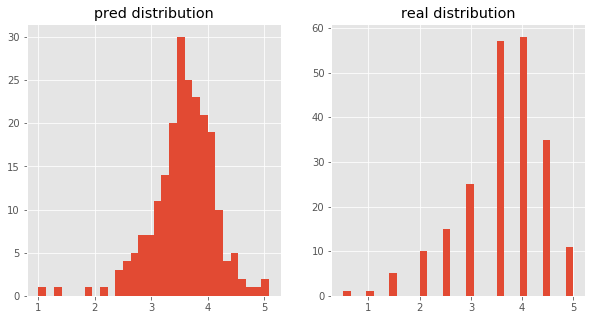

In [13]:
from sklearn.preprocessing import minmax_scale

# user id from 0 ~ 670
uid = 22
u_queries, movies_meta = list(user_item_data(trProcessed, [uid], movie_trans))[0]
with tf.Session(graph=model.graph) as sess:
    pred = model.predict(sess, u_queries, movies_meta)
print("shape: ", pred.shape, minmax_scale(pred.T).T)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribution")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribution")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

<br/>
<br/>
<br/>
## evaluate model

In [14]:
%%time
n_batch = 128
with tf.Session(graph=model.graph) as sess:
    mae_ = model.evaluateMAE(sess, dataFn(teProcessed, n_batch=n_batch, shuffle=False))
    rmse_ = model.evaluateRMSE(sess, dataFn(teProcessed, n_batch=n_batch, shuffle=False))

print()
print("MAE loss: ", mae_)
print("RMSE loss: ", rmse_)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10

MAE loss:  0.61102539663
RMSE loss:  0.805394906236
Wall time: 5.22 s


#### User導向評估(Recall)

In [15]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    u_queries, movies_meta = list(user_item_data(trProcessed, [uid], movie_trans))[0]
    recomm = model.predict(sess, u_queries, movies_meta).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)), 
              "title": midMap[np.arange(len(recomm))].values, 
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False).head(50)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10


,userId,movieId,title,rating,predRating
4417,22,4417,Catch Me If You Can (2002),5.0,3.874622
5623,22,5623,Undertow (2004),5.0,4.978449
4419,22,4419,"Hours, The (2002)",5.0,3.717790
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,4.152204
4371,22,4371,Adaptation (2002),5.0,3.694263
4008,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,3.859646
6132,22,6132,Crash (2004),5.0,3.879870
5016,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,4.268062
5761,22,5761,Duel (1971),5.0,3.931752
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.085468


#### Model導向評估(Precision)

In [16]:
# .query("rating != 0")
recommDf.query("rating != 0").sort_values("predRating", ascending=False).head(50)

,userId,movieId,title,rating,predRating
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,5.085468
5623,22,5623,Undertow (2004),5.0,4.978449
4751,22,4751,Ikiru (1952),4.0,4.816934
3957,22,3957,"Bad and the Beautiful, The (1952)",4.0,4.681274
4724,22,4724,Umberto D. (1952),4.5,4.581068
5369,22,5369,Viridiana (1961),3.5,4.578466
5227,22,5227,Zorba the Greek (Alexis Zorbas) (1964),4.0,4.491716
4910,22,4910,"Passion of Joan of Arc, The (Passion de Jeanne...",4.0,4.454527
4241,22,4241,Heaven (2002),4.5,4.430748
6185,22,6185,Last Days (2005),4.0,4.429634


#### ROC_CURVE (Receiver operating characteristic), AUC (Area Under Curve)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
auc: 0.814852274431


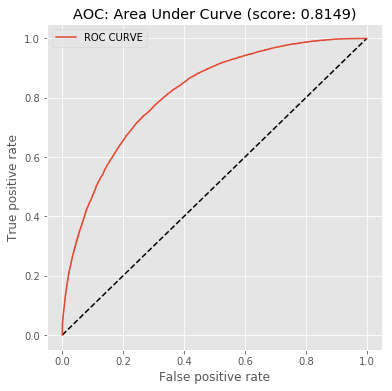

In [17]:
def drawRocCurve(y, predProba):
    fprRf, tprRf, _ = roc_curve(y, predProba, pos_label=1)
    aucScr = auc(fprRf, tprRf)
    print("auc:", aucScr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('AOC: Area Under Curve (score: {:.4f})'.format(aucScr))
    ax.legend(loc='best')
    plt.show()

coord = teRatingMat.nonzero()
with tf.Session(graph=model.graph) as sess:
    predMat = []
    for u_data, items in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=128):
        predMat.append(model.predict(sess, u_data, items))
        # predMat.append(model.predict(sess, u_data))
    predMat = np.vstack(predMat)
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])

In [ ]:
pos_ary, neg_ary = [], []
for label in teRatingMat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    # print("pos: {}, neg: {}".format(sum(label >= 4), sum(label < 4)))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.show()

# 可調整index觀察各user rating分布 ex: [0:10] [10:20] [600:610]
draw_pos_neg(np.arange(len(teRatingMat))[0:100])

### About Test Data Movie Ratings(觀察上圖)
```
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也指得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高
```

In [19]:
_ = sum(np.sum(teRatingMat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))

266 個user正向評價總數小於10!


In [18]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0
    
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in teRatingMat)))

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in teRatingMat)))

rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


#### Precision At K: 
> **預測分數高(rating >= 4)的前10部電影, 和實際user rating比較, 觀察命中率**

In [20]:
%%time
from sklearn.metrics import precision_score

def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

n_batch = 128
with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    for u_data, i_data in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data, i_data))
    pred_mat = np.vstack(pred_mat)
    
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
strict condition precision at 10:  0.6004784689
norm condition precision at 10:  0.692077727952
Wall time: 1.5 s


### NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [25]:
def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return utils.ndcg_score(label, score, k)

def all_user_ndcg(label, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(teRatingMat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    for u_data, items in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=128):
        pred_mat.append(model.predict(sess, u_data, items))
    pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
strict condition ndcg at 10:  0.739559092569
norm condition ndcg at 10:  0.834940359695


#### Recall At K: 
> **對於每個user喜歡的前10部電影中(rating >= 4), 和預測值比較, 觀察命中率**

In [24]:
%%time
from sklearn.metrics import recall_score

def recall_at_k(truth, pred_mat, condition_fn, k=10, label_thres=4, pred_thres=0.8):
    hits, total = 0, 0
    for labels, pr in zip(truth, pred_mat):
        if not condition_fn(labels): continue

        top_percentile = np.percentile(pr, pred_thres * 100)
        top_k_ind = labels.argsort()[::-1][:k]
        hits += sum(pr[top_k_ind] >= top_percentile)
        # hits += recall_score(labels >= label_thres, pr >= np.percentile(pr, pred_thres * 100))
        total += k
    return hits / total
    
n_batch = 128
with tf.Session(graph=model.graph) as sess:
    pred_mat = []
    for u_data, i_data in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data, i_data))
    pred_mat = np.vstack(pred_mat)
    
def recall_cond_fn(label):
    """recall條件限制為, user在test data正向評價電影至少10部"""
    return sum(label >= 4) >= 10
    
print( recall_at_k(teRatingMat, pred_mat, condition_fn=recall_cond_fn) )

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10
0.363703703704
Wall time: 14.9 s


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## MF + DNN with Cross Entropy Loss Function (Sigmoid Cross Entropy)

## 在Rating只有1(正向) or 0(負向)時該如何處理?
```python
1. 繼承ModelMfDNN, 改動loss function, 因為使用sigmoid, rating欄位需要變成0 or 1
2. 每一個epoch觀察cross entropy的loss之外, 也觀察RMSE loss的變化(計算RMSE維持原rating)
3. 許多狀況很難拿到user explicit feedback, 像是movie rating, 因為沒法強迫user去rating所有movies, 
   但是應該都能夠蒐集到implicit feedback
   ex: youtube影片觀看時間長短, 點擊率, 通常implicit feedback只能歸納為到 [0, 1] 之間, 0代表negative, 1代表positive
```

In [21]:
class ModelMfDNNCrossEntropy(ModelMfDNN):
    def __init__(self,
                 n_items,
                 n_genres,
                 dim=32,
                 learning_rate=0.01,
                 modelDir="./model/model_mf_with_dnn_xent"):
        """初始化 ModelBase Tensorflow Graph"""
        self.n_items = n_items
        self.n_genres = n_genres
        self.ftr_cols = OrderedDict()

        graph = tf.Graph()
        with graph.as_default():
            # inputs/id_user:0
            with tf.variable_scope("inputs"):
                self.isTrain = tf.placeholder(tf.bool, None)
                # user data
                self.user_id = tf.placeholder(tf.int32, [None])
                self.query_movie_ids = tf.placeholder(tf.int32, [None, None])
                self.query_movie_ids_len = tf.placeholder(tf.int32, [None])
                # item data
                self.genres = tf.placeholder(tf.int32, [None, None])
                self.genres_len = tf.placeholder(tf.int32, [None])
                self.avg_rating = tf.placeholder(tf.float32, [None])
                self.year = tf.placeholder(tf.float32, [None])
                self.candidate_movie_id = tf.placeholder(tf.int32, [None])
                # labels
                self.rating = tf.placeholder(tf.float32, [None])

            init_fn = tf.glorot_normal_initializer()
            emb_init_fn = tf.glorot_uniform_initializer()
            self.b_global = tf.Variable(emb_init_fn(shape=[]), name="b_global")
            with tf.variable_scope("embedding"):
                self.w_query_movie_ids = tf.Variable(emb_init_fn(shape=[self.n_items, dim]), name="w_query_movie_ids")
                self.b_query_movie_ids = tf.Variable(emb_init_fn(shape=[dim]), name="b_query_movie_ids")
                self.w_candidate_movie_id = tf.Variable(init_fn(shape=[self.n_items, dim]), name="w_candidate_movie_id")
                self.b_candidate_movie_id = tf.Variable(init_fn(shape=[dim + 8 + 2]), name="b_candidate_movie_id")
                self.w_genres = tf.Variable(emb_init_fn(shape=[self.n_genres, 8]), name="w_genres")

                # query_movie embedding
                self.query_emb = tf.nn.embedding_lookup(self.w_query_movie_ids, self.query_movie_ids)
                query_movie_mask = tf.expand_dims(tf.nn.l2_normalize(tf.to_float(tf.sequence_mask(self.query_movie_ids_len)), 1), -1)
                self.query_emb = tf.reduce_sum(self.query_emb * query_movie_mask, 1)
                self.query_bias = tf.matmul(self.query_emb, self.b_query_movie_ids[:, tf.newaxis])

                # candidate_movie embedding
                self.candidate_emb = tf.nn.embedding_lookup(self.w_candidate_movie_id, self.candidate_movie_id)

                # genres embedding
                self.genres_emb = tf.nn.embedding_lookup(self.w_genres, tf.to_int32(self.genres))
                genres_mask = tf.expand_dims( tf.nn.l2_normalize(tf.to_float(tf.sequence_mask( tf.reshape(self.genres_len, [-1])) ), 1), -1)
                self.genres_emb = tf.reduce_sum(self.genres_emb * genres_mask, 1)

            # encode [item embedding + item metadata]
            with tf.variable_scope("dnn"):
                self.item_repr = tf.concat([self.candidate_emb, self.genres_emb, self.avg_rating[:, tf.newaxis], self.year[:, tf.newaxis]], 1)
                self.candidate_bias = tf.matmul(self.item_repr, self.b_candidate_movie_id[:, tf.newaxis])
                
                # self.item_repr = tf.layers.dropout(self.item_repr, 0.5, training=self.isTrain)
                self.item_repr = tf.layers.dense(self.item_repr, dim, kernel_initializer=init_fn, activation=tf.nn.relu)
                # self.item_repr = tf.layers.dropout(self.item_repr, 0.5, training=self.isTrain)
                self.item_repr = tf.layers.dense(self.item_repr, dim, kernel_initializer=init_fn, activation=tf.nn.relu)
                # self.item_repr = tf.layers.dropout(self.item_repr, 0.5, training=self.isTrain)

            with tf.variable_scope("computation"):
                infer = tf.reduce_sum(self.query_emb * self.item_repr, 1, keep_dims=True)
                infer = tf.add(infer, self.b_global)
                infer = tf.add(infer, self.query_bias)
                self.infer = tf.add(infer, self.candidate_bias, name="infer")

                # one query for all items
                self.pred = tf.matmul(self.query_emb, tf.transpose(self.item_repr)) + \
                            tf.reshape(self.candidate_bias, (1, -1)) + self.query_bias + self.b_global
                self.pred = tf.nn.sigmoid(self.pred)
                pass

            with tf.variable_scope("loss"):
                # if rating >= 4 then 1 else 0
                self.alter_rating = tf.to_float(self.rating >= 4)
                self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.alter_rating[:, np.newaxis], logits=self.infer))

                # for eval
                self.rmse_loss = tf.sqrt(tf.losses.mean_squared_error(labels=self.alter_rating[:, tf.newaxis], predictions=self.infer))
                self.mae_loss = tf.reduce_mean(tf.abs(self.infer - self.alter_rating[:, tf.newaxis]))
                pass

            with tf.variable_scope("train"):
                # try: 選擇不同的optimizer
                self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
                # self.train_op = tf.train.AdagradOptimizer(learning_rate).minimize(self.loss)
                # self.train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(self.loss)
                # self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
                pass

            self.saver = tf.train.Saver(tf.global_variables())
            self.graph = graph
            self.modelDir = modelDir
            
    def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
        sess.run(tf.global_variables_initializer())
        if reset:
            print("reset model: clean model dir: {} ...".format(self.modelDir))
            self.resetModel(self.modelDir)
        # try: 試著重上次儲存的model再次training
        self.ckpt(sess, self.modelDir)

        start = time.time()
        print("%s\t%s\t%s\t%s\t%s" % ("Epoch", "XEntropy Error", "Val XENT Error", "Val RMSE Error", "Elapsed Time"))
        minLoss = 1e7
        for ep in range(1, nEpoch + 1):
            tr_loss, tr_total =  0, 0
            for i, data in enumerate(trainGen(), 1):
                loss, _ = sess.run([self.loss, self.train_op], feed_dict=self.feed_dict(data, mode="train"))
                batch_len = len(data["query_movie_ids"])
                tr_loss += loss * batch_len
                tr_total += batch_len
                print("\rtrain loss: {:.3f}".format(loss), end="")
                
            if testGen is not None:
                te_rmse_loss, te_xent_loss  = self.epochLoss(sess, testGen)

            tpl = "\r%02d\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f secs"
            if minLoss > te_xent_loss:
                tpl += ", saving ..."
                self.saver.save(sess, os.path.join(self.modelDir, 'model'), global_step=ep)
                minLoss = te_xent_loss

            end = time.time()
            print(tpl % (ep, tr_loss / tr_total, te_xent_loss, te_rmse_loss, end - start))
            start = end
        return self

    def epochLoss(self, sess, dataGen):
        tot_xent_loss, tot_rmse_loss, tot_cnt = 0, 0, 0
        for data in dataGen():
            xent_loss, rmse_loss = sess.run([self.loss, self.rmse_loss], feed_dict=self.feed_dict(data, mode="eval"))
            batch_len = len(data["query_movie_ids"])
            tot_rmse_loss += rmse_loss ** 2 * batch_len
            tot_xent_loss += xent_loss * batch_len
            tot_cnt += batch_len
        return np.sqrt(tot_rmse_loss / tot_cnt), tot_xent_loss / tot_cnt
            
# Do: 調整 learning rate: [0.1, 0.01, 0.05, 0.0001]
learning_rate = 0.1
# Do: 調整 dim [8, 16, 20, 32]
dim = 16
# Do: 非必要: 置換 model directory, 建議都放在 ./model 底下
modelDir = "./model/model_mf_with_dnn_xent"
        
tf.reset_default_graph()
model_xent = ModelMfDNNCrossEntropy(
                n_items=nMovies,
                n_genres=n_genres,
                dim=dim,
                learning_rate=learning_rate,
                modelDir=modelDir)

## Trainging

In [66]:
n_batch = 128
with tf.Session(graph=model_xent.graph) as sess:
    model_xent.fit(sess, dataFn(trProcessed, n_batch=n_batch, shuffle=True), dataFn(teProcessed, n_batch=n_batch), nEpoch=15, reset=True)

reset model: clean model dir: ./model/model_mf_with_dnn_xent ...
Epoch	XEntropy Error	Val XENT Error	Val RMSE Error	Elapsed Time
01	0.661		0.628		0.689		15.093 secs, saving ...
02	0.613		0.593		0.847		15.618 secs, saving ...
03	0.584		0.572		0.893		14.178 secs, saving ...
04	0.563		0.564		1.085		15.844 secs, saving ...
05	0.550		0.553		1.142		14.290 secs, saving ...
06	0.540		0.541		1.144		15.665 secs, saving ...
07	0.531		0.541		1.335		14.630 secs, saving ...
08	0.524		0.534		1.390		15.577 secs, saving ...
09	0.520		0.546		1.246		13.795 secs
10	0.517		0.525		1.396		14.755 secs, saving ...
11	0.514		0.524		1.488		15.678 secs, saving ...
12	0.513		0.529		1.621		13.686 secs
13	0.511		0.550		1.784		14.165 secs
14	0.510		0.533		1.696		14.152 secs
15	0.508		0.535		1.705		14.201 secs


#### ROC_CURVE (Receiver operating characteristic), AUC (Area Under Curve)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
auc: 0.817434936864


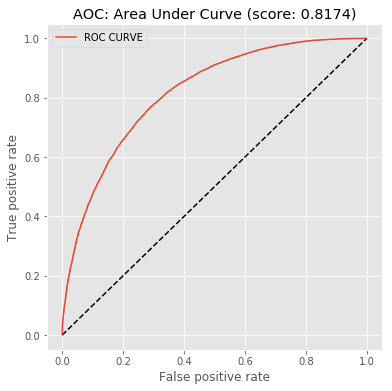

In [22]:
def drawRocCurve(y, predProba):
    fprRf, tprRf, _ = roc_curve(y, predProba, pos_label=1)
    aucScr = auc(fprRf, tprRf)
    print("auc:", aucScr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('AOC: Area Under Curve (score: {:.4f})'.format(aucScr))
    ax.legend(loc='best')
    plt.show()

coord = teRatingMat.nonzero()
with tf.Session(graph=model_xent.graph) as sess:
    predMat = []
    for u_data, items in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=128):
        predMat.append(model_xent.predict(sess, u_data, items))
    predMat = np.vstack(predMat)
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])

### 觀察單一user與預測分布圖

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
shape:  (1, 9125) [[ 0.506   0.1629  0.1371 ...,  0.9458  0.5108  0.4098]]


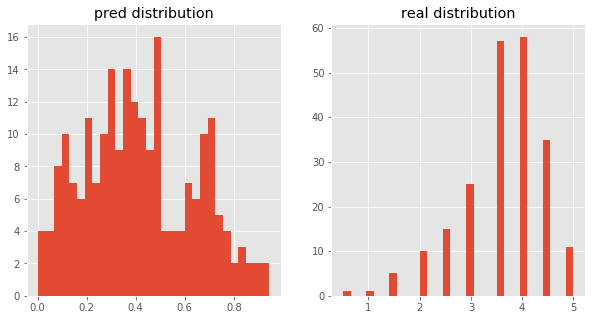

In [12]:
from sklearn.preprocessing import minmax_scale

# user id from 0 ~ 670
uid = 22
u_queries, movies_meta = list(user_item_data(trProcessed, [uid], movie_trans))[0]
with tf.Session(graph=model_xent.graph) as sess:
    pred = model_xent.predict(sess, u_queries, movies_meta)
print("shape: ", pred.shape, minmax_scale(pred.T).T)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribution")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribution")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

#### User導向評估(Recall)

In [13]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 25
with tf.Session(graph=model_xent.graph) as sess:
    u_queries, movies_meta = list(user_item_data(trProcessed, [uid], movie_trans))[0]
    recomm = model_xent.predict(sess, u_queries, movies_meta).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)), 
              "title": midMap[np.arange(len(recomm))].values, 
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False).head(50)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11


,userId,movieId,title,rating,predRating
7143,25,7143,Ip Man (2008),5.0,0.529229
7004,25,7004,Watchmen (2009),5.0,0.365489
6966,25,6966,Kung Fu Panda (2008),5.0,0.351901
6628,25,6628,Ratatouille (2007),5.0,0.511091
6947,25,6947,Taken (2008),5.0,0.303991
6916,25,6916,"Dark Knight, The (2008)",5.0,0.651332
6746,25,6746,"Bourne Ultimatum, The (2007)",5.0,0.492064
6387,25,6387,Inside Man (2006),4.5,0.499242
6708,25,6708,Mr. Brooks (2007),4.5,0.568636
7435,25,7435,Soul Kitchen (2009),4.5,0.785341


#### Model導向評估(Precision)

In [14]:
recommDf.query("rating != 0").sort_values("predRating", ascending=False).head(50)

,userId,movieId,title,rating,predRating
7435,25,7435,Soul Kitchen (2009),4.5,0.785341
6539,25,6539,"Departed, The (2006)",4.5,0.687607
6916,25,6916,"Dark Knight, The (2008)",5.0,0.651332
6698,25,6698,This Is England (2006),4.0,0.650371
6556,25,6556,"Prestige, The (2006)",4.5,0.637534
7209,25,7209,Inglourious Basterds (2009),3.5,0.617001
7987,25,7987,Intouchables (2011),4.5,0.585372
6856,25,6856,There Will Be Blood (2007),3.5,0.581688
6708,25,6708,Mr. Brooks (2007),4.5,0.568636
6583,25,6583,Blood Diamond (2006),4.0,0.564912


### Precision At 10

In [23]:
%%time
from sklearn.metrics import precision_score

def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

n_batch = 128
with tf.Session(graph=model_xent.graph) as sess:
    pred_mat = []
    for u_data, i_data in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=n_batch):
        pred_mat.append(model_xent.predict(sess, u_data, i_data))
    pred_mat = np.vstack(pred_mat)
    
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
strict condition precision at 10:  0.592822966507
norm condition precision at 10:  0.688191330344
Wall time: 1.48 s


### NDCG

In [26]:
with tf.Session(graph=model_xent.graph) as sess:
    pred_mat = []
    for u_data, items in user_item_data(teProcessed, np.arange(nUsers), movie_trans, n_batch=128):
        pred_mat.append(model_xent.predict(sess, u_data, items))
    pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11
strict condition ndcg at 10:  0.728602070187
norm condition ndcg at 10:  0.827161184717


<br/>
<br/>
<br/>
## 取出movies embedding, 使用cosine similarity列出最相似的電影

In [27]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [28]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def most_like(model, seed_movie, k=10):
    """給定某一部電影, 使用model裡movies embedding找尋cosine相似度高的其他電影!"""
    with tf.Session(graph=model.graph) as sess:
        model.ckpt(sess, model.modelDir)
        user_queries, items = list(user_item_data(trProcessed, [0], movie_trans))[0]
        movie_emb = sess.run(model.item_repr, feed_dict={
            model.isTrain: False,
            model.genres: items["genres"],
            model.genres_len: items["genres_len"],
            model.avg_rating: items["avg_rating"],
            model.year: items["year"],
            model.candidate_movie_id: items["candidate_movie_id"]
        })
        
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

# mse訓練出來的model
most_like(model, 0, k=11)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn\model-10


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3805,3805,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
7672,7672,Tangled (2010),Animation|Children|Comedy|Fantasy|Musical|Roma...
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
5839,5839,Ghost Dad (1990),Comedy|Fantasy
6341,6341,Hoodwinked! (2005),Animation|Children|Comedy
8928,8928,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy
8676,8676,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy
1866,1866,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
4610,4610,Finding Nemo (2003),Adventure|Animation|Children|Comedy


In [31]:
# cross entropy訓練出來的model
most_like(model_xent, 0, k=11)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_dnn_xent\model-11


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3805,3805,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
7373,7373,Black Dynamite (2009),Action|Comedy
7343,7343,"Haunted World of El Superbeasto, The (2009)",Action|Animation|Comedy|Horror|Thriller
3419,3419,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
215,215,Gordy (1995),Children|Comedy|Fantasy
7653,7653,Red (2010),Action|Comedy
7525,7525,Exit Through the Gift Shop (2010),Comedy|Documentary
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy


<br/>
<br/>
<br/>
## Observations
```
1. 可觀察到使用movie embedding以cosine相似度找相似的movie已經有效果, 但是我們用的並不是自己組合出來的movie features, 而是embedding
   代表在training當中已經讓embedding是有意義的代表movie.
```